In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [8]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf', regex=True)
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'r2', 'n_iter']] = cv_results[[
        'param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_r2', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [9]:
from sklearn.datasets import make_regression
from optiml.ml.utils import generate_nonlinearly_regression_data

lin_X, lin_y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_regression_data(random_state=123456)

## Epsilon-insensitive loss

### Primal formulation

In [10]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [11]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    
    if hasattr(svr, 'train_loss_history'):
        
        # (f_t - f^*) / f^*
        f_star = np.full_like(svr.train_loss_history, svr.loss.f_star())
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                              np.maximum(abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(lin_y - svr.predict(lin_X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits


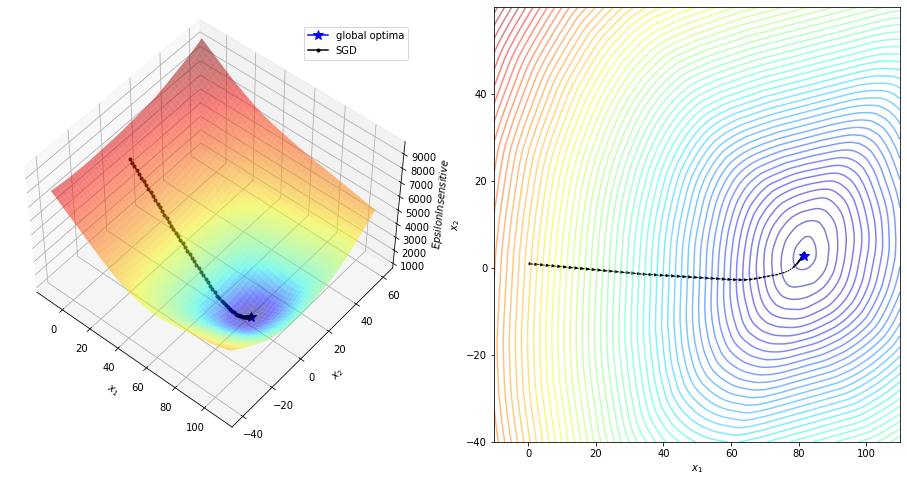

In [12]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                x_min=-10, x_max=110, y_min=-40, y_max=60)
eps_loss_opt = plot_trajectory_optimization(eps_loss, grid.best_estimator_.optimizer, 
                                            color='k', label='SGD')

In [13]:
none_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l1_svr_cv_results.insert(0, 'solver', 'sgd')
none_primal_l1_svr_cv_results.insert(1, 'momentum', 'none')
none_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.715262  0.317278    1000   100
                    0.2      0.752715  0.317278    1000   100
                    0.3      0.723708  0.317278    1000   100
                10  0.1      0.650643  0.983893     806    98
                    0.2      0.787620  0.983891     884    98
                    0.3      0.812846  0.983884     958    97
                100 0.1      0.120071  0.984034      85    97
                    0.2      0.116307  0.984047      96    98
                    0.3      0.125313  0.984056     109    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits


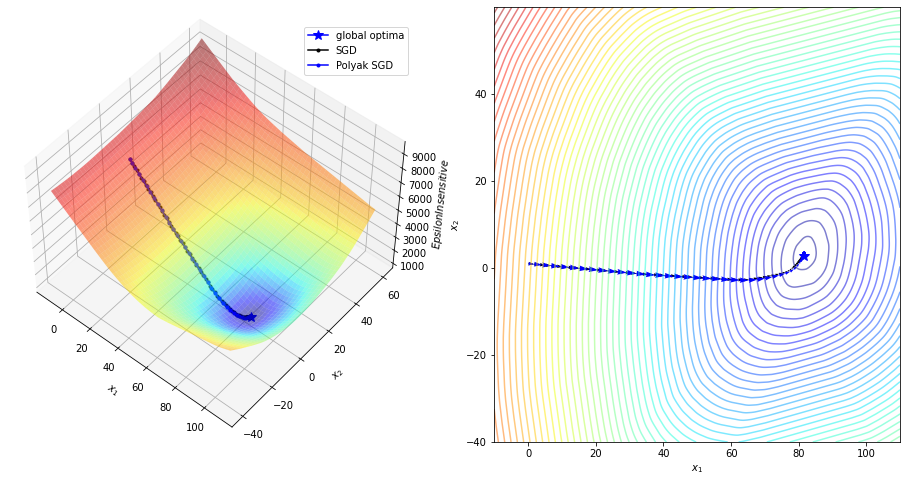

In [14]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='b', label='Polyak SGD')
eps_loss_opt

In [15]:
polyak_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l1_svr_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l1_svr_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
polyak_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    polyak   1   0.1      0.763742  0.481504    1000   100
                    0.2      0.805388  0.481504    1000   100
                    0.3      0.811253  0.481504    1000   100
                10  0.1      0.427298  0.983893     487    97
                    0.2      0.503465  0.983891     535    98
                    0.3      0.561612  0.983885     569    98
                100 0.1      0.100317  0.984030      48    98
                    0.2      0.084031  0.984046      56    98
                    0.3      0.103578  0.984055      61    97

Fitting 1 folds for each of 9 candidates, totalling 9 fits


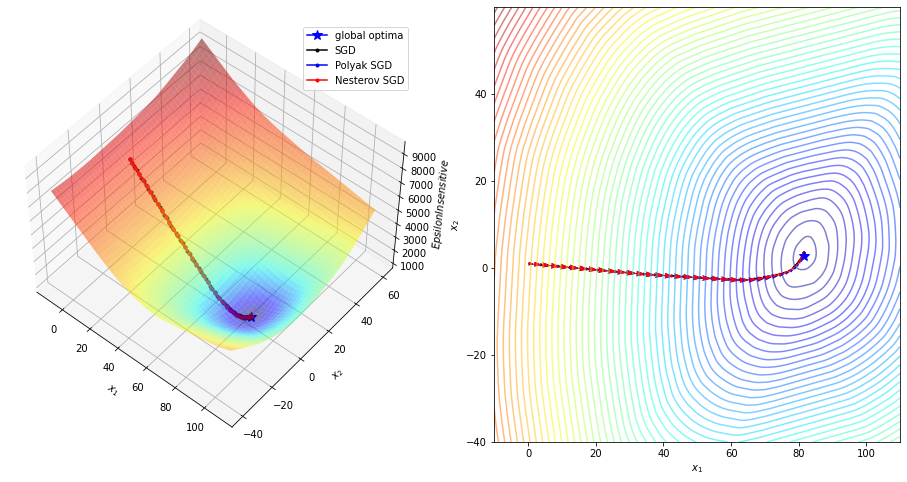

In [16]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='r', label='Nesterov SGD')
eps_loss_opt.savefig('./tex/img/l1_svr_loss.png')
eps_loss_opt

In [17]:
nesterov_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l1_svr_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l1_svr_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      1.263293  0.481456    1000   100
                    0.2      0.885720  0.481456    1000   100
                    0.3      0.865447  0.481456    1000   100
                10  0.1      0.477645  0.983892     489    97
                    0.2      0.479729  0.983890     533    97
                    0.3      0.453526  0.983884     579    98
                100 0.1      0.083007  0.984031      61    98
                    0.2      0.107250  0.984047      58    98
                    0.3      0.088824  0.984057      62    98

In [18]:
custom_primal_l1_svr_cv_results = none_primal_l1_svr_cv_results.append(
    polyak_primal_l1_svr_cv_results).append(
    nesterov_primal_l1_svr_cv_results)
custom_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.715262  0.317278    1000   100
                    0.2      0.752715  0.317278    1000   100
                    0.3      0.723708  0.317278    1000   100
                10  0.1      0.650643  0.983893     806    98
                    0.2      0.787620  0.983891     884    98
                    0.3      0.812846  0.983884     958    97
                100 0.1      0.120071  0.984034      85    97
                    0.2      0.116307  0.984047      96    98
                    0.3      0.125313  0.984056     109    98
       polyak   1   0.1      0.763742  0.481504    1000   100
                    0.2      0.805388  0.481504    1000   100
                    0.3      0.811253  0.481504    1000   100
                10  0.1      0.427298  0.983893     487    97
                    0.2      0.503465  0.983891     535    98
                    0.3      0.561612  0.983885     569    98
                100 0.1      0.100317  0.984030      48    98
                    0.2      0.084031  0.984046      56    98
                    0.3      0.103578  0.984055      61    97
       nesterov 1   0.1      1.263293  0.481456    1000   100
                    0.2      0.885720  0.481456    1000   100
                    0.3      0.865447  0.481456    1000   100
                10  0.1      0.477645  0.983892     489    97
                    0.2      0.479729  0.983890     533    97
                    0.3      0.453526  0.983884     579    98
                100 0.1      0.083007  0.984031      61    98
                    0.2      0.107250  0.984047      58    98
                    0.3      0.088824  0.984057      62    98

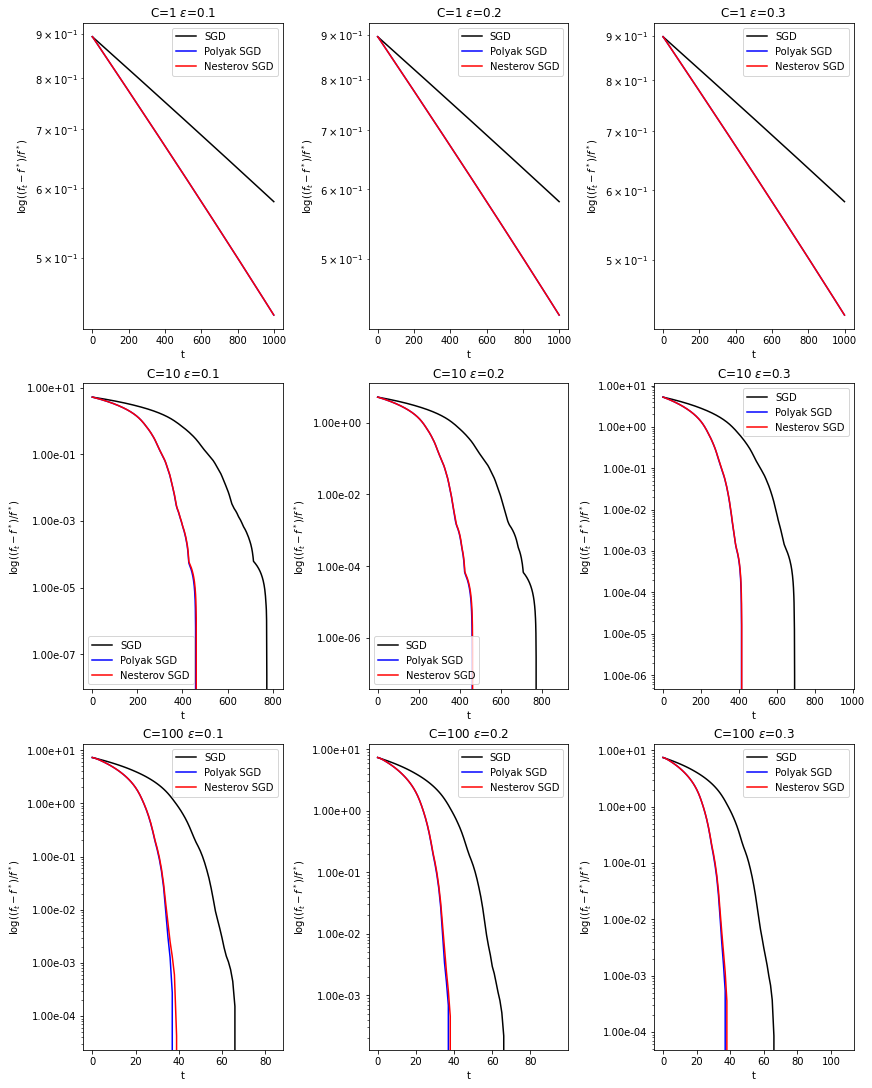

In [19]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svr_loss_history.png')

In [20]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive', 
                                random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [21]:
liblinear_primal_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l1_svr_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l1_svr_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l1_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001284  0.954684      12   100
                       0.2      0.001281  0.955112      10    99
                       0.3      0.001283  0.955415      10    97
                   10  0.1      0.001798  0.983893      57    99
                       0.2      0.002159  0.983890      69    98
                       0.3      0.001407  0.983906     142    97
                   100 0.1      0.001979  0.984023     980    97
                       0.2      0.002865  0.984029    1000    97
                       0.3      0.002111  0.984069    1000    97

In [22]:
primal_l1_svr_cv_results = custom_primal_l1_svr_cv_results.append(liblinear_primal_l1_svr_cv_results)
primal_l1_svr_cv_results.to_latex('./tex/experiments/primal_l1_svr.tex', 
                                  caption='Primal $\protect \mathcal{L}_1$-SVR results', 
                                  label='primal_l1_svr_cv_results', position='H')
primal_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      0.715262  0.317278    1000   100
                       0.2      0.752715  0.317278    1000   100
                       0.3      0.723708  0.317278    1000   100
                   10  0.1      0.650643  0.983893     806    98
                       0.2      0.787620  0.983891     884    98
                       0.3      0.812846  0.983884     958    97
                   100 0.1      0.120071  0.984034      85    97
                       0.2      0.116307  0.984047      96    98
                       0.3      0.125313  0.984056     109    98
          polyak   1   0.1      0.763742  0.481504    1000   100
                       0.2      0.805388  0.481504    1000   100
                       0.3      0.811253  0.481504    1000   100
                   10  0.1      0.427298  0.983893     487    97
                       0.2      0.503465  0.983891     535    98
                       0.3      0.561612  0.983885     569    98
                   100 0.1      0.100317  0.984030      48    98
                       0.2      0.084031  0.984046      56    98
                       0.3      0.103578  0.984055      61    97
          nesterov 1   0.1      1.263293  0.481456    1000   100
                       0.2      0.885720  0.481456    1000   100
                       0.3      0.865447  0.481456    1000   100
                   10  0.1      0.477645  0.983892     489    97
                       0.2      0.479729  0.983890     533    97
                       0.3      0.453526  0.983884     579    98
                   100 0.1      0.083007  0.984031      61    98
                       0.2      0.107250  0.984047      58    98
                       0.3      0.088824  0.984057      62    98
liblinear -        1   0.1      0.001284  0.954684      12   100
                       0.2      0.001281  0.955112      10    99
                       0.3      0.001283  0.955415      10    97
                   10  0.1      0.001798  0.983893      57    99
                       0.2      0.002159  0.983890      69    98
                       0.3      0.001407  0.983906     142    97
                   100 0.1      0.001979  0.984023     980    97
                       0.2      0.002865  0.984029    1000    97
                       0.3      0.002111  0.984069    1000    97

### Dual formulations

In [23]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import LagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [24]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [25]:
train_loss_history = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def dual_r2_scorer(svr, X, y):
    
    if (hasattr(svr, 'train_loss_history') and
                isinstance(svr.obj, LagrangianQuadratic)):
        
        # (f_t - f^*) / f^*
        f_star = np.full_like(svr.train_loss_history, svr.obj.f_star())
        dual = 'reg_bias' if svr.reg_intercept else 'unreg_bias'
        kernel = svr.kernel.__class__.__name__
        train_loss_history[dual][kernel][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                         np.maximum(abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0: -1.1167e+04 -2.5701e+05  2e+05  0e+00  9e-15
 1: -6.2479e+04 -9.8509e+04  4e+04  2e-16  1e-14
 2: -8.0376e+04 -8.6953e+04  7e+03  2e-16  9e-15
 3: -8.3021e+04 -8.5265e+04  2e+03  2e-16  1e-14
 4: -8.4092e+04 -8.4496e+04  4e+02  2e-16  1e-14
 5: -8.4260e+04 -8.4362e+04  1e+02  2e-16  1e-14
 6: -8.4314e+04 -8.4316e+04  2e+00  2e-16  1e-14
 7: -8.4315e+04 -8.4315e+04  2e-02  2e-16  1e-14
Optimal solution found.


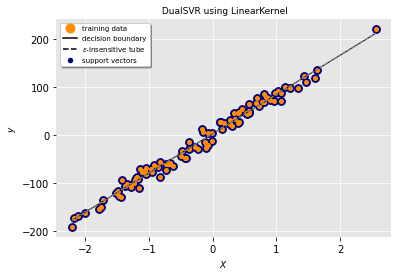

In [26]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            kernel=LinearKernel()),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svr_hyperplane.png')

In [27]:
custom_linear_dual_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_l1_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_l1_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
cvxopt 1   0.1      0.117298  0.954685       9   100
           0.2      0.088846  0.954849       9   100
           0.3      0.199592  0.955429      10   100
       10  0.1      0.118282  0.983893       9   100
           0.2      0.156507  0.983893       8   100
           0.3      0.081468  0.983893       8   100
       100 0.1      0.094990  0.984071       9   100
           0.2      0.065072  0.984088       9   100
           0.3      0.087518  0.984103       8   100
smo    1   0.1      0.073597  0.954396      10   100
           0.2      0.030771  0.954546      15   100
           0.3      0.061113  0.955429      13    99
       10  0.1      0.263360  0.983893      44    99
           0.2      0.167492  0.983893      48    99
           0.3      0.139349  0.983893      41    99
       100 0.1      0.847388  0.984071     623    98
           0.2      0.442487  0.984088     157    98
           0.3      0.609627  0.984103     334    98

In [28]:
grid = GridSearchCV(SklSVR(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[LibSVM]

In [29]:
libsvm_linear_dual_l1_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_l1_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_l1_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
libsvm 1   0.1      0.024892  0.954393      79   100
           0.2      0.007021  0.954543      82   100
           0.3      0.002929  0.955424      78    99
       10  0.1      0.005642  0.983892     206    99
           0.2      0.015230  0.983890     219    99
           0.3      0.005720  0.983885     216    99
       100 0.1      0.009251  0.984028    2239    98
           0.2      0.003608  0.984041    1189    98
           0.3      0.003550  0.984051    1366    98

In [30]:
linear_dual_l1_svr_cv_results = custom_linear_dual_l1_svr_cv_results.append(libsvm_linear_dual_l1_svr_cv_results)
linear_dual_l1_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], ascending=[False, True, True], inplace=True)
linear_dual_l1_svr_cv_results.to_latex('./tex/experiments/linear_dual_l1_svr.tex', 
                                       caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVR results', 
                                       label='linear_dual_l1_svr_cv_results', position='H')
linear_dual_l1_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
smo    1   0.1      0.073597  0.954396      10   100
           0.2      0.030771  0.954546      15   100
           0.3      0.061113  0.955429      13    99
       10  0.1      0.263360  0.983893      44    99
           0.2      0.167492  0.983893      48    99
           0.3      0.139349  0.983893      41    99
       100 0.1      0.847388  0.984071     623    98
           0.2      0.442487  0.984088     157    98
           0.3      0.609627  0.984103     334    98
libsvm 1   0.1      0.024892  0.954393      79   100
           0.2      0.007021  0.954543      82   100
           0.3      0.002929  0.955424      78    99
       10  0.1      0.005642  0.983892     206    99
           0.2      0.015230  0.983890     219    99
           0.3      0.005720  0.983885     216    99
       100 0.1      0.009251  0.984028    2239    98
           0.2      0.003608  0.984041    1189    98
           0.3      0.003550  0.984051    1366    98
cvxopt 1   0.1      0.117298  0.954685       9   100
           0.2      0.088846  0.954849       9   100
           0.3      0.199592  0.955429      10   100
       10  0.1      0.118282  0.983893       9   100
           0.2      0.156507  0.983893       8   100
           0.3      0.081468  0.983893       8   100
       100 0.1      0.094990  0.984071       9   100
           0.2      0.065072  0.984088       9   100
           0.3      0.087518  0.984103       8   100

##### Nonlinear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  1.9943e+03 -2.2457e+04  2e+04  0e+00  5e-10
 1:  1.6485e+03 -1.4960e+03  3e+03  1e-16  4e-10
 2:  2.7294e+02 -1.9201e+02  5e+02  2e-16  3e-10
 3:  4.7106e+01 -3.8722e+01  9e+01  2e-16  1e-10
 4:  9.1882e+00 -9.5019e+00  2e+01  2e-16  3e-11
 5:  4.8977e-01 -1.8622e+00  2e+00  2e-16  4e-12
 6:  2.9291e-01 -1.6173e+00  2e+00  2e-16  2e-12
 7: -4.0534e-01 -9.5519e-01  5e-01  2e-16  9e-13
 8: -6.7624e-01 -7.0485e-01  3e-02  2e-16  5e-13
 9: -6.9005e-01 -6.9035e-01  3e-04  2e-16  5e-13
10: -6.9019e-01 -6.9020e-01  3e-06  2e-16  4e-13
11: -6.9019e-01 -6.9019e-01  3e-08  2e-16  5e-13
Optimal solution found.


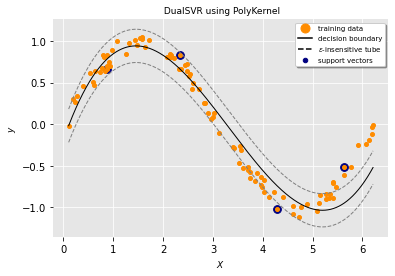

In [31]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svr_hyperplane.png')

In [32]:
poly_nonlinear_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_l2_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_l2_svr_cv_results

fit_time        r2   n_iter  n_sv
solver kernel C   epsilon                                      
cvxopt poly   1   0.1         0.230761  0.828482       10    37
                  0.2         0.132333  0.666571       10     6
                  0.3         0.109379  0.350876        9     4
              10  0.1         0.063353  0.629433       10    33
                  0.2         0.062518  0.928477       10     4
                  0.3         0.133498  0.350873       10     4
              100 0.1         0.116879  0.712681       10    36
                  0.2         0.155555  0.928478       10     4
                  0.3         0.080267  0.350876       10     4
smo    poly   1   0.1        68.392890  0.810056    47694    36
                  0.2        14.370649  0.671256     8702     6
                  0.3         5.386392  0.302709     3654     4
              10  0.1       300.062039  0.736098   256531    32
                  0.2        41.746667  0.923152    32629     4
                  0.3         4.519509  0.302709     3654     4
              100 0.1      1751.245163  0.635585  3294613    33
                  0.2        39.353246  0.923152    32629     4
                  0.3         4.833264  0.302709     3654     4

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  9.9722e+02 -2.3019e+04  2e+04  0e+00  1e-12
 1:  8.8761e+02 -1.3911e+03  2e+03  1e-16  2e-12
 2:  1.7095e+02 -1.6286e+02  3e+02  1e-16  1e-12
 3:  2.8000e+01 -5.5447e+01  8e+01  2e-16  5e-13
 4:  1.9850e+00 -3.1537e+01  3e+01  2e-16  3e-13
 5: -1.1406e+01 -1.8729e+01  7e+00  2e-16  3e-13
 6: -1.4158e+01 -1.6108e+01  2e+00  2e-16  2e-13
 7: -1.4924e+01 -1.5333e+01  4e-01  2e-16  3e-13
 8: -1.5103e+01 -1.5153e+01  5e-02  2e-16  3e-13
 9: -1.5127e+01 -1.5128e+01  1e-03  2e-16  3e-13
10: -1.5127e+01 -1.5127e+01  1e-05  2e-16  3e-13
Optimal solution found.


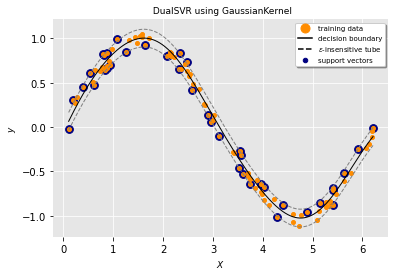

In [33]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svr_hyperplane.png')

In [34]:
rbf_nonlinear_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_l2_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel C   epsilon                                  
cvxopt rbf    1   0.1      0.056430  0.988117      10    17
                  0.2      0.037635  0.924679      10     7
                  0.3      0.031585  0.883386      10     5
              10  0.1      0.033969  0.989956      10    18
                  0.2      0.034816  0.925595      10     6
                  0.3      0.039004  0.883386      10     5
              100 0.1      0.026327  0.990216      10    40
                  0.2      0.036008  0.925595      10     6
                  0.3      0.030514  0.883386      10     5
smo    rbf    1   0.1      0.058076  0.988244      66    17
                  0.2      0.018418  0.924292      20     7
                  0.3      0.015674  0.883022      17     5
              10  0.1      0.463563  0.989739     389    18
                  0.2      0.014622  0.924995      25     6
                  0.3      0.012374  0.882816      11     5
              100 0.1      3.754668  0.974756    6664    19
                  0.2      0.026766  0.924995      25     6
                  0.3      0.014341  0.882816      11     5

In [35]:
custom_nonlinear_dual_l2_svr_cv_results = poly_nonlinear_dual_l2_svr_cv_results.append(rbf_nonlinear_dual_l2_svr_cv_results)
custom_nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_l2_svr_cv_results

fit_time        r2   n_iter  n_sv
solver kernel C   epsilon                                      
cvxopt poly   1   0.1         0.230761  0.828482       10    37
                  0.2         0.132333  0.666571       10     6
                  0.3         0.109379  0.350876        9     4
              10  0.1         0.063353  0.629433       10    33
                  0.2         0.062518  0.928477       10     4
                  0.3         0.133498  0.350873       10     4
              100 0.1         0.116879  0.712681       10    36
                  0.2         0.155555  0.928478       10     4
                  0.3         0.080267  0.350876       10     4
       rbf    1   0.1         0.056430  0.988117       10    17
                  0.2         0.037635  0.924679       10     7
                  0.3         0.031585  0.883386       10     5
              10  0.1         0.033969  0.989956       10    18
                  0.2         0.034816  0.925595       10     6
                  0.3         0.039004  0.883386       10     5
              100 0.1         0.026327  0.990216       10    40
                  0.2         0.036008  0.925595       10     6
                  0.3         0.030514  0.883386       10     5
smo    poly   1   0.1        68.392890  0.810056    47694    36
                  0.2        14.370649  0.671256     8702     6
                  0.3         5.386392  0.302709     3654     4
              10  0.1       300.062039  0.736098   256531    32
                  0.2        41.746667  0.923152    32629     4
                  0.3         4.519509  0.302709     3654     4
              100 0.1      1751.245163  0.635585  3294613    33
                  0.2        39.353246  0.923152    32629     4
                  0.3         4.833264  0.302709     3654     4
       rbf    1   0.1         0.058076  0.988244       66    17
                  0.2         0.018418  0.924292       20     7
                  0.3         0.015674  0.883022       17     5
              10  0.1         0.463563  0.989739      389    18
                  0.2         0.014622  0.924995       25     6
                  0.3         0.012374  0.882816       11     5
              100 0.1         3.754668  0.974756     6664    19
                  0.2         0.026766  0.924995       25     6
                  0.3         0.014341  0.882816       11     5

In [36]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[LibSVM]

In [37]:
libsvm_nonlinear_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_l2_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_l2_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_l2_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_l2_svr_cv_results

fit_time        r2    n_iter  n_sv
solver kernel C   epsilon                                    
libsvm poly   1   0.1      0.065797  0.981438    155092    37
                  0.2      0.009269  0.976358      7326     6
                  0.3      0.005210  0.951282      3969     4
              10  0.1      0.168651  0.981769    578347    32
                  0.2      0.019524  0.979414     28452     4
                  0.3      0.004664  0.951282      3969     4
              100 0.1      2.585694  0.981844  13306191    35
                  0.2      0.014572  0.979414     28452     4
                  0.3      0.016183  0.951282      3969     4
       rbf    1   0.1      0.004845  0.990088        96    17
                  0.2      0.008893  0.977763        36     7
                  0.3      0.001747  0.945601        24     5
              10  0.1      0.002936  0.990493       616    18
                  0.2      0.009552  0.980673        39     6
                  0.3      0.001880  0.945601        24     5
              100 0.1      0.022821  0.990496      9854    18
                  0.2      0.001701  0.980673        39     6
                  0.3      0.001951  0.945601        24     5

In [38]:
nonlinear_dual_l2_svr_cv_results = custom_nonlinear_dual_l2_svr_cv_results.append(libsvm_nonlinear_dual_l2_svr_cv_results)
nonlinear_dual_l2_svr_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_l2_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svr.tex', 
                                          caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVR formulation results', 
                                          label='nonlinear_dual_l1_svr_cv_results', position='H')
nonlinear_dual_l2_svr_cv_results

fit_time        r2    n_iter  n_sv
solver kernel C   epsilon                                       
smo    poly   1   0.1        68.392890  0.810056     47694    36
                  0.2        14.370649  0.671256      8702     6
                  0.3         5.386392  0.302709      3654     4
              10  0.1       300.062039  0.736098    256531    32
                  0.2        41.746667  0.923152     32629     4
                  0.3         4.519509  0.302709      3654     4
              100 0.1      1751.245163  0.635585   3294613    33
                  0.2        39.353246  0.923152     32629     4
                  0.3         4.833264  0.302709      3654     4
       rbf    1   0.1         0.058076  0.988244        66    17
                  0.2         0.018418  0.924292        20     7
                  0.3         0.015674  0.883022        17     5
              10  0.1         0.463563  0.989739       389    18
                  0.2         0.014622  0.924995        25     6
                  0.3         0.012374  0.882816        11     5
              100 0.1         3.754668  0.974756      6664    19
                  0.2         0.026766  0.924995        25     6
                  0.3         0.014341  0.882816        11     5
libsvm poly   1   0.1         0.065797  0.981438    155092    37
                  0.2         0.009269  0.976358      7326     6
                  0.3         0.005210  0.951282      3969     4
              10  0.1         0.168651  0.981769    578347    32
                  0.2         0.019524  0.979414     28452     4
                  0.3         0.004664  0.951282      3969     4
              100 0.1         2.585694  0.981844  13306191    35
                  0.2         0.014572  0.979414     28452     4
                  0.3         0.016183  0.951282      3969     4
       rbf    1   0.1         0.004845  0.990088        96    17
                  0.2         0.008893  0.977763        36     7
                  0.3         0.001747  0.945601        24     5
              10  0.1         0.002936  0.990493       616    18
                  0.2         0.009552  0.980673        39     6
                  0.3         0.001880  0.945601        24     5
              100 0.1         0.022821  0.990496      9854    18
                  0.2         0.001701  0.980673        39     6
                  0.3         0.001951  0.945601        24     5
cvxopt poly   1   0.1         0.230761  0.828482        10    37
                  0.2         0.132333  0.666571        10     6
                  0.3         0.109379  0.350876         9     4
              10  0.1         0.063353  0.629433        10    33
                  0.2         0.062518  0.928477        10     4
                  0.3         0.133498  0.350873        10     4
              100 0.1         0.116879  0.712681        10    36
                  0.2         0.155555  0.928478        10     4
                  0.3         0.080267  0.350876        10     4
       rbf    1   0.1         0.056430  0.988117        10    17
                  0.2         0.037635  0.924679        10     7
                  0.3         0.031585  0.883386        10     5
              10  0.1         0.033969  0.989956        10    18
                  0.2         0.034816  0.925595        10     6
                  0.3         0.039004  0.883386        10     5
              100 0.1         0.026327  0.990216        10    40
                  0.2         0.036008  0.925595        10     6
                  0.3         0.030514  0.883386        10     5

#### Lagrangian Dual

##### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/m

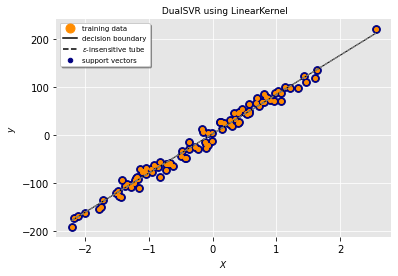

In [39]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)

In [40]:
linear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svr.tex', 
                                                  caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVR results', 
                                                  label='linear_lagrangian_dual_l1_svr_cv_results', position='H')
linear_lagrangian_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       C   epsilon                                   
reg_bias   1   0.1       9.014390  0.954684   10000   100
               0.2       9.522141  0.954846   10000   100
               0.3       9.484683  0.955429   10000   100
           10  0.1       9.553555  0.983899   10000   100
               0.2       9.195415  0.983899   10000   100
               0.3       9.738081  0.983891   10000   100
           100 0.1       9.059696  0.984086   10000   100
               0.2       9.252517  0.984088   10000   100
               0.3       9.079562  0.984096   10000   100
unreg_bias 1   0.1       9.273358  0.954395   10000   100
               0.2       9.031577  0.954535   10000   100
               0.3       9.171732  0.955454   10000    99
           10  0.1       9.490612  0.983892   10000   100
               0.2      10.196379  0.983894   10000   100
               0.3       9.208535  0.983890   10000   100
           100 0.1       8.796887  0.983995   10000   100
               0.2       9.366341  0.984055   10000   100
               0.3       9.269228  0.984072   10000   100

##### Nonlinear

Fitting 1 folds for each of 36 candidates, totalling 36 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/m

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1536: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/m

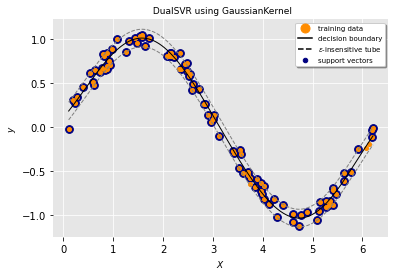

In [41]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)

In [42]:
nonlinear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svr.tex', 
                                                     caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVR results', 
                                                     label='nonlinear_lagrangian_dual_l1_svr_cv_results', position='H')
nonlinear_lagrangian_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       kernel C   epsilon                                   
reg_bias   poly   1   0.1       8.753738  0.980649   10000   100
                      0.2       8.196864  0.981475   10000   100
                      0.3       8.575808  0.980750   10000   100
                  10  0.1       9.458230  0.980042   10000   100
                      0.2       8.525160  0.980724   10000   100
                      0.3       8.916882  0.974359   10000   100
                  100 0.1       8.869521  0.981125   10000   100
                      0.2       8.441144  0.981479   10000   100
                      0.3       9.133370  0.978966   10000    99
           rbf    1   0.1       9.224121  0.990052   10000    81
                      0.2      10.106396  0.964400   10000    61
                      0.3      10.219767  0.952099   10000    54
                  10  0.1       9.175098  0.989754   10000    92
                      0.2      10.355982  0.983904   10000    43
                      0.3      10.386412  0.956593   10000    43
                  100 0.1       9.102558  0.989818   10000    86
                      0.2      10.319922  0.984017   10000    71
                      0.3      10.361556  0.937889   10000    70
unreg_bias poly   1   0.1       8.627309  0.981039   10000   100
                      0.2       8.490436  0.978000   10000   100
                      0.3       7.721025  0.977036   10000    99
                  10  0.1       9.866277  0.978251   10000   100
                      0.2       8.645740  0.981917   10000    99
                      0.3       7.725760  0.977723   10000   100
                  100 0.1       8.925465  0.978305   10000   100
                      0.2      10.440119  0.980187   10000   100
                      0.3       7.783286  0.965960   10000   100
           rbf    1   0.1      10.031470  0.989985   10000    90
                      0.2       9.228424  0.974585   10000    73
                      0.3       9.231140  0.937354   10000    75
                  10  0.1       9.533357  0.989713   10000    87
                      0.2       9.193305  0.974184   10000    75
                      0.3       9.457048  0.954241   10000    67
                  100 0.1       9.800612  0.989624   10000    93
                      0.2       9.465609  0.983461   10000    72
                      0.3      10.547809  0.942005   10000    82

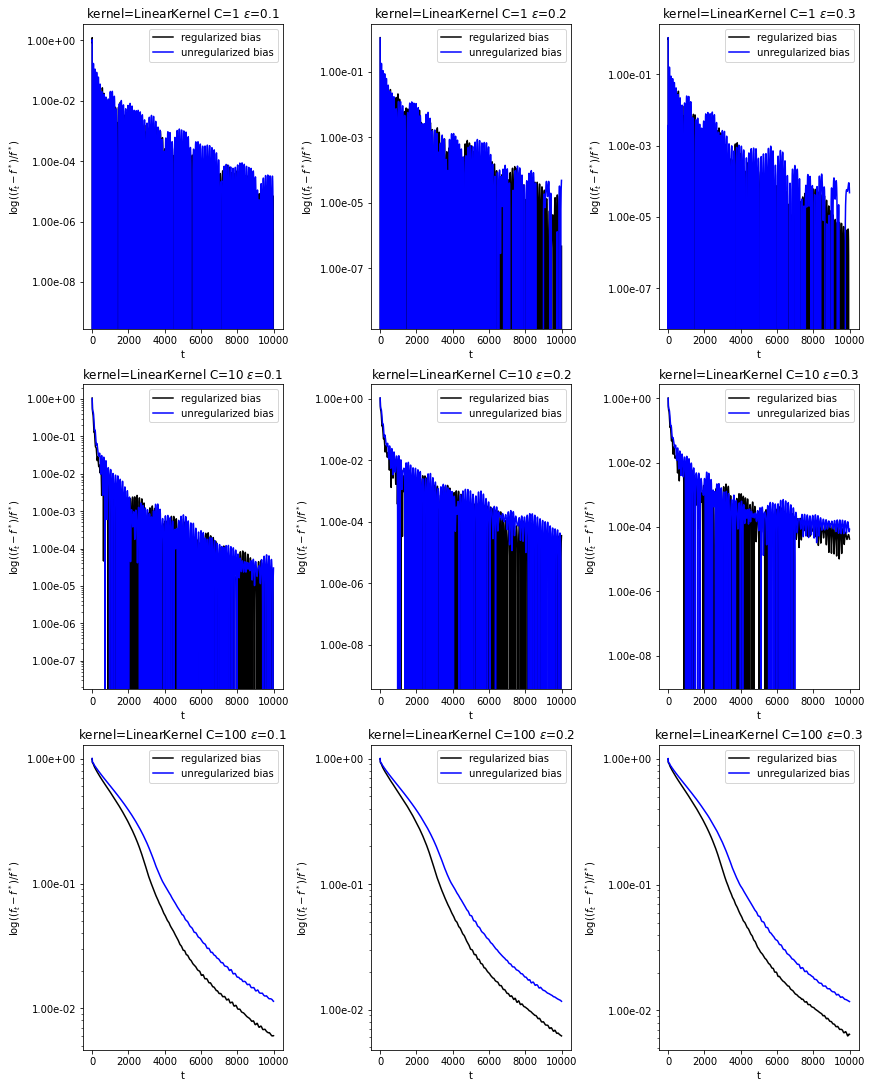

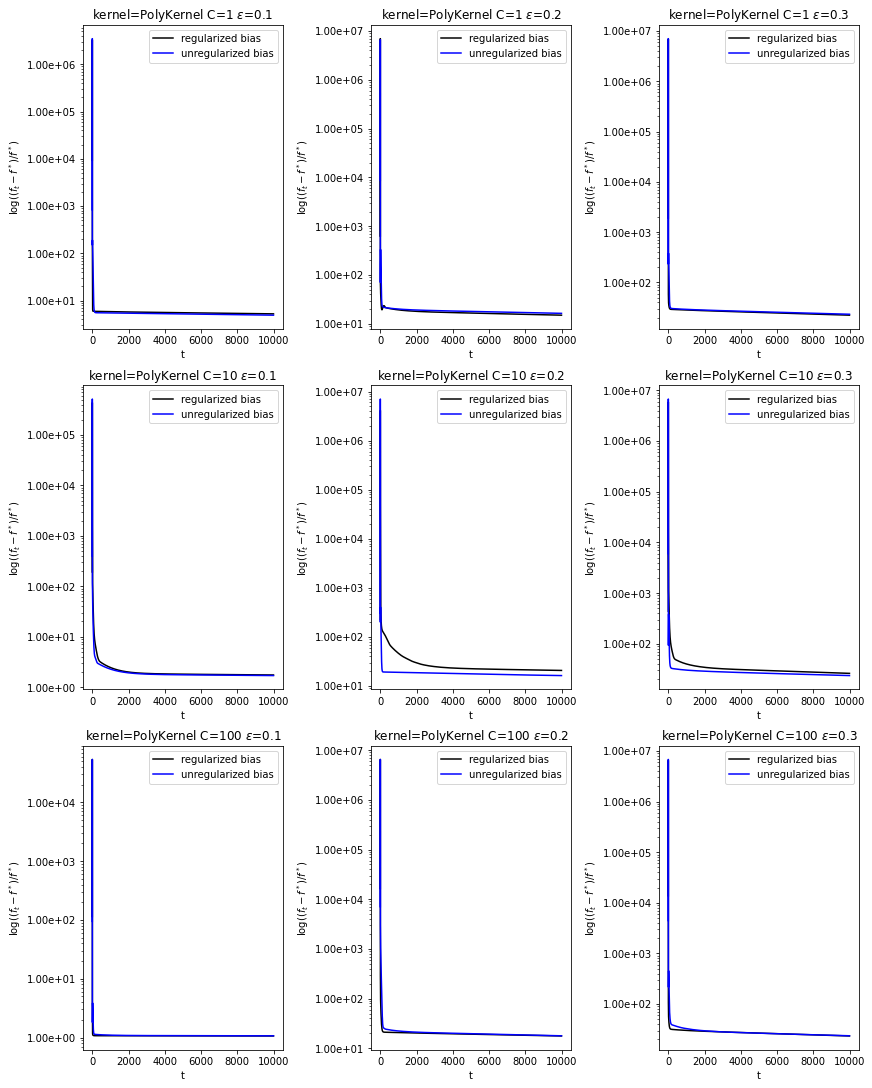

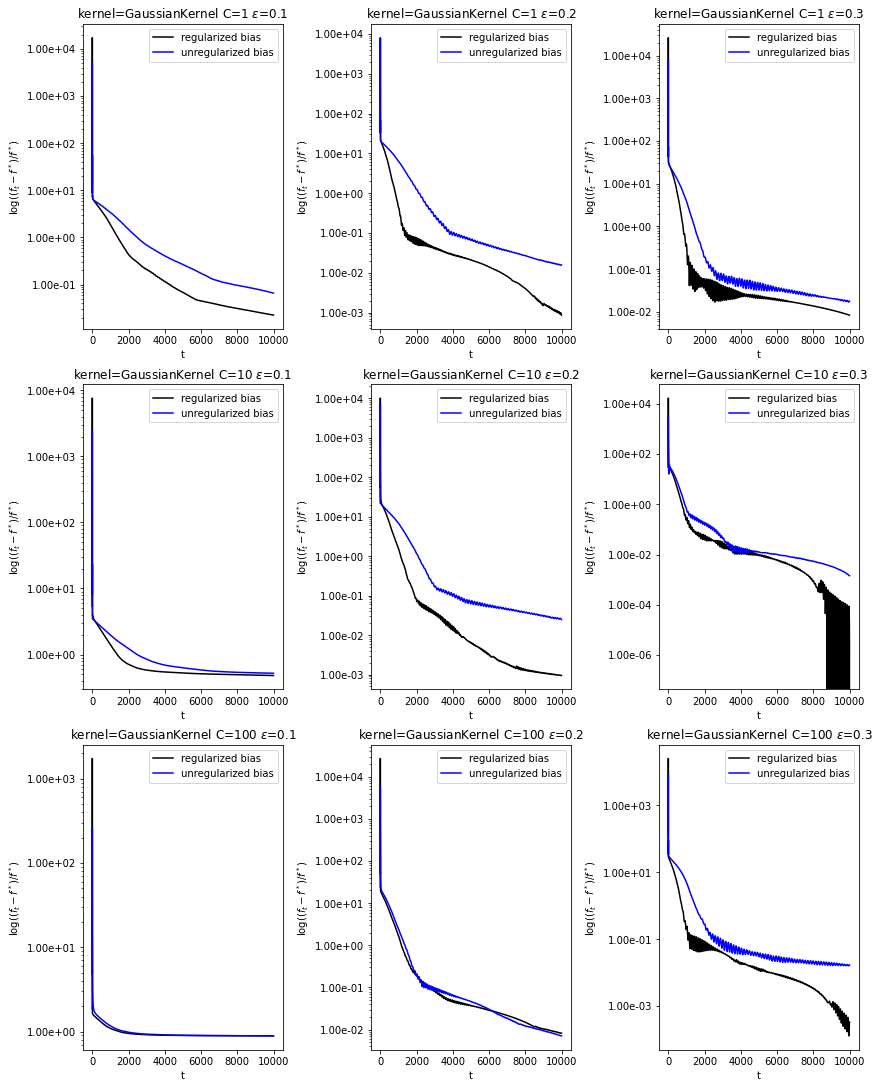

In [43]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
linear_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
linear_ax = linear_fig.subplots(3, 3)
poly_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
poly_ax = poly_fig.subplots(3, 3)
gaussian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
gaussian_ax = gaussian_fig.subplots(3, 3)
axes = {'LinearKernel': linear_ax,
        'PolyKernel': poly_ax,
        'GaussianKernel': gaussian_ax}
for dual, _dict1 in train_loss_history.items():
    for kernel, _dict2 in _dict1.items():
        for (C, _dict3), row_ax in zip(_dict2.items(), axes[kernel]):
            for (eps, history), loss in zip(_dict3.items(), row_ax):
                loss.plot(history, color=colors[dual][0], label=colors[dual][1])
                loss.set_title('kernel={} C={:d} $\epsilon$={:.1f}'.format(kernel, C, eps))
                loss.set_xlabel('t')
                loss.set_yscale('log')
                loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
                loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
                loss.legend().get_frame().set_facecolor('white')
linear_fig.savefig('./tex/img/linear_lagrangian_dual_l1_svr_loss_history.png')
poly_fig.savefig('./tex/img/poly_lagrangian_dual_l1_svr_loss_history.png')
gaussian_fig.savefig('./tex/img/gaussian_lagrangian_dual_l1_svr_loss_history.png')

## Squared Epsilon-insensitive loss

### Primal formulation

In [44]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [45]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    
    if hasattr(svr, 'train_loss_history'):
        
        # (f_t - f^*) / f^*
        f_star = np.full_like(svr.train_loss_history, svr.loss.f_star())
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                              np.maximum(abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(lin_y - svr.predict(lin_X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits


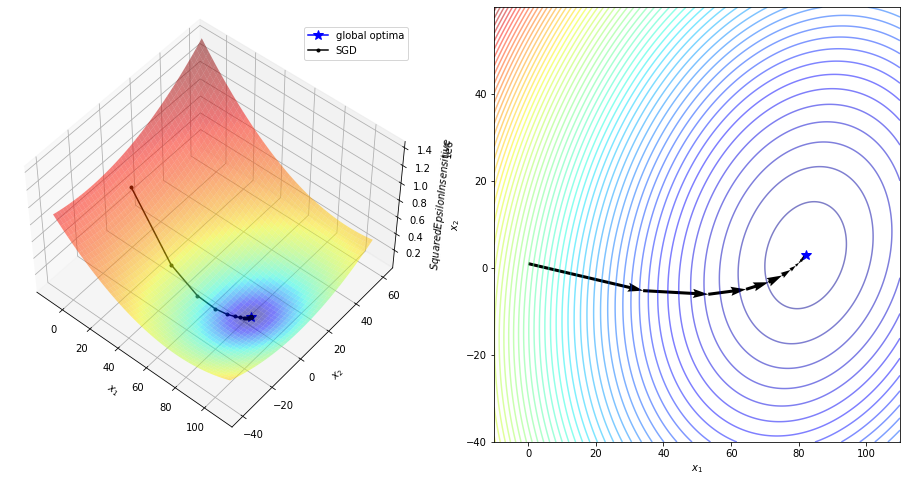

In [46]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.002, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                        x_min=-10, x_max=110, y_min=-40, y_max=60)
squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss, grid.best_estimator_.optimizer, 
                                                    color='k', label='SGD')

In [47]:
none_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l2_svr_cv_results.insert(0, 'solver', 'sgd')
none_primal_l2_svr_cv_results.insert(1, 'momentum', 'none')
none_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.328131  0.983264    1000    99
                    0.2      0.370263  0.983235    1000    98
                    0.3      0.374990  0.983206    1000    97
                10  0.1      0.184656  0.984133     409    98
                    0.2      0.186013  0.984133     410    98
                    0.3      0.185521  0.984133     411    98
                100 0.1      0.033478  0.984133      47    98
                    0.2      0.036156  0.984133      47    98
                    0.3      0.036809  0.984133      47    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits


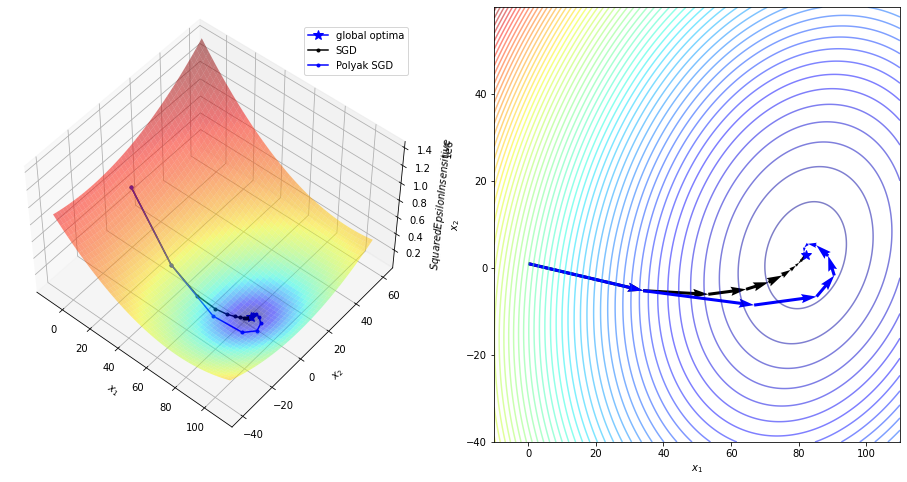

In [48]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.002, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='b', label='Polyak SGD')
squared_eps_loss_opt

In [49]:
polyak_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l2_svr_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l2_svr_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
polyak_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    polyak   1   0.1      0.323868  0.984078    1000    99
                    0.2      0.369074  0.984077    1000    99
                    0.3      0.372964  0.984075    1000    99
                10  0.1      0.128660  0.984133     241    98
                    0.2      0.133996  0.984133     242    98
                    0.3      0.135180  0.984133     243    98
                100 0.1      0.029155  0.984133      40    98
                    0.2      0.030236  0.984133      40    98
                    0.3      0.031384  0.984133      40    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits


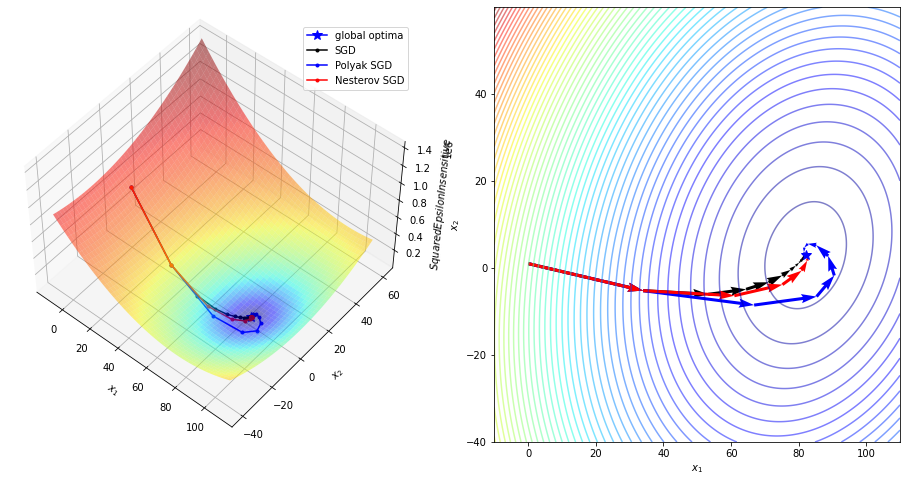

In [50]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.002, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='r', label='Nesterov SGD')
squared_eps_loss_opt.savefig('./tex/img/l2_svr_loss.png')
squared_eps_loss_opt

In [51]:
nesterov_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l2_svr_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l2_svr_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      0.341465  0.984078    1000    99
                    0.2      0.371013  0.984076    1000    99
                    0.3      0.372786  0.984075    1000    99
                10  0.1      0.132163  0.984133     247    98
                    0.2      0.134339  0.984133     248    98
                    0.3      0.134644  0.984133     248    98
                100 0.1      0.019208  0.984133      27    98
                    0.2      0.021056  0.984133      27    98
                    0.3      0.021436  0.984133      27    98

In [52]:
custom_primal_l2_svr_cv_results = none_primal_l2_svr_cv_results.append(
    polyak_primal_l2_svr_cv_results).append(
    nesterov_primal_l2_svr_cv_results)
custom_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.328131  0.983264    1000    99
                    0.2      0.370263  0.983235    1000    98
                    0.3      0.374990  0.983206    1000    97
                10  0.1      0.184656  0.984133     409    98
                    0.2      0.186013  0.984133     410    98
                    0.3      0.185521  0.984133     411    98
                100 0.1      0.033478  0.984133      47    98
                    0.2      0.036156  0.984133      47    98
                    0.3      0.036809  0.984133      47    98
       polyak   1   0.1      0.323868  0.984078    1000    99
                    0.2      0.369074  0.984077    1000    99
                    0.3      0.372964  0.984075    1000    99
                10  0.1      0.128660  0.984133     241    98
                    0.2      0.133996  0.984133     242    98
                    0.3      0.135180  0.984133     243    98
                100 0.1      0.029155  0.984133      40    98
                    0.2      0.030236  0.984133      40    98
                    0.3      0.031384  0.984133      40    98
       nesterov 1   0.1      0.341465  0.984078    1000    99
                    0.2      0.371013  0.984076    1000    99
                    0.3      0.372786  0.984075    1000    99
                10  0.1      0.132163  0.984133     247    98
                    0.2      0.134339  0.984133     248    98
                    0.3      0.134644  0.984133     248    98
                100 0.1      0.019208  0.984133      27    98
                    0.2      0.021056  0.984133      27    98
                    0.3      0.021436  0.984133      27    98

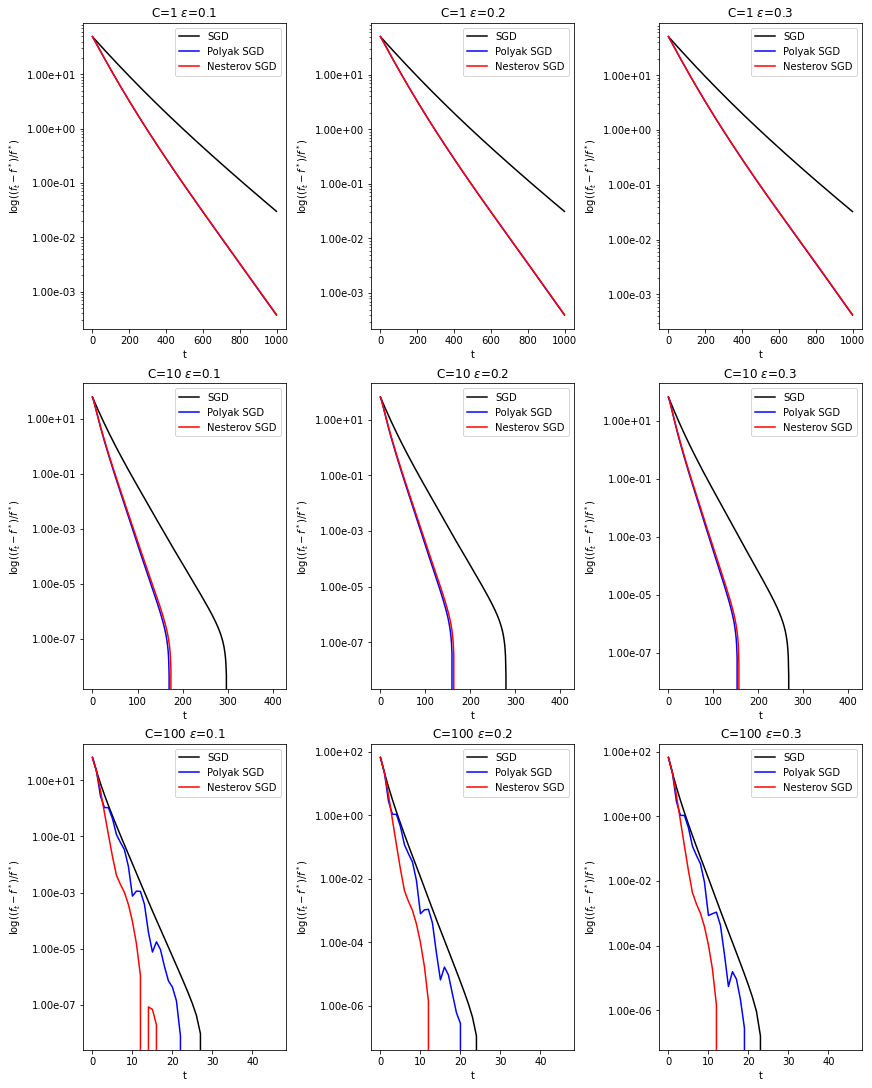

In [53]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svr_loss_history.png')

In [54]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive', 
                                random_state=123456),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [55]:
liblinear_primal_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l2_svr_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l2_svr_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l2_svr_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001616  0.984109      84   100
                       0.2      0.001572  0.984109      84   100
                       0.3      0.001806  0.984109      84    98
                   10  0.1      0.004764  0.984133     778    98
                       0.2      0.005359  0.984133     773    98
                       0.3      0.004638  0.984133     773    98
                   100 0.1      0.004611  0.984126    1000   100
                       0.2      0.006202  0.984127    1000    98
                       0.3      0.007255  0.984128    1000    98

In [56]:
primal_l2_svr_cv_results = custom_primal_l2_svr_cv_results.append(liblinear_primal_l2_svr_cv_results)
primal_l2_svr_cv_results.to_latex('./tex/experiments/primal_l2_svr.tex', 
                                  caption='Primal $\protect \mathcal{L}_2$-SVR results', 
                                  label='primal_l2_svr_cv_results', position='H')
primal_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      0.328131  0.983264    1000    99
                       0.2      0.370263  0.983235    1000    98
                       0.3      0.374990  0.983206    1000    97
                   10  0.1      0.184656  0.984133     409    98
                       0.2      0.186013  0.984133     410    98
                       0.3      0.185521  0.984133     411    98
                   100 0.1      0.033478  0.984133      47    98
                       0.2      0.036156  0.984133      47    98
                       0.3      0.036809  0.984133      47    98
          polyak   1   0.1      0.323868  0.984078    1000    99
                       0.2      0.369074  0.984077    1000    99
                       0.3      0.372964  0.984075    1000    99
                   10  0.1      0.128660  0.984133     241    98
                       0.2      0.133996  0.984133     242    98
                       0.3      0.135180  0.984133     243    98
                   100 0.1      0.029155  0.984133      40    98
                       0.2      0.030236  0.984133      40    98
                       0.3      0.031384  0.984133      40    98
          nesterov 1   0.1      0.341465  0.984078    1000    99
                       0.2      0.371013  0.984076    1000    99
                       0.3      0.372786  0.984075    1000    99
                   10  0.1      0.132163  0.984133     247    98
                       0.2      0.134339  0.984133     248    98
                       0.3      0.134644  0.984133     248    98
                   100 0.1      0.019208  0.984133      27    98
                       0.2      0.021056  0.984133      27    98
                       0.3      0.021436  0.984133      27    98
liblinear -        1   0.1      0.001616  0.984109      84   100
                       0.2      0.001572  0.984109      84   100
                       0.3      0.001806  0.984109      84    98
                   10  0.1      0.004764  0.984133     778    98
                       0.2      0.005359  0.984133     773    98
                       0.3      0.004638  0.984133     773    98
                   100 0.1      0.004611  0.984126    1000   100
                       0.2      0.006202  0.984127    1000    98
                       0.3      0.007255  0.984128    1000    98

### Lagrangian Dual

In [57]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import LagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [58]:
train_loss_history = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def dual_r2_scorer(svr, X, y):
    
    # (f_t - f^*) / f^*
    f_star = np.full_like(svr.train_loss_history, svr.obj.f_star())
    dual = 'reg_bias' if svr.reg_intercept else 'unreg_bias'
    kernel = svr.kernel.__class__.__name__
    train_loss_history[dual][kernel][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                     np.maximum(abs(f_star), 1))
    
    return {'r2': svr.score(X, y), 
            'n_iter': svr.optimizer.iter + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/m

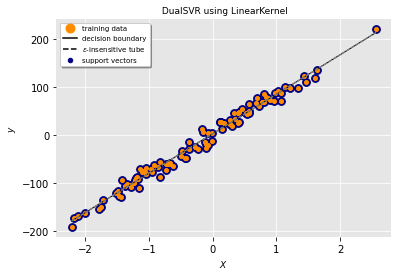

In [59]:
grid = GridSearchCV(DualSVR(loss=squared_epsilon_insensitive, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)

In [60]:
linear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l2_svr.tex', 
                                                  caption='Lagrangian Dual linear $\protect \mathcal{L}_2$-SVR results', 
                                                  label='linear_lagrangian_dual_l2_svr_cv_results', position='H')
linear_lagrangian_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       C   epsilon                                  
reg_bias   1   0.1      8.886250  0.984109   10000   100
               0.2      8.447072  0.984109   10000   100
               0.3      8.493953  0.984109   10000    98
           10  0.1      8.203294  0.984133   10000   100
               0.2      8.320815  0.984133   10000   100
               0.3      8.490490  0.984133   10000    98
           100 0.1      8.775280  0.984129   10000   100
               0.2      9.019509  0.984130   10000   100
               0.3      9.022733  0.984131   10000   100
unreg_bias 1   0.1      8.186003  0.984109   10000   100
               0.2      9.028857  0.984109   10000   100
               0.3      9.081488  0.984109   10000    98
           10  0.1      9.138670  0.984133   10000   100
               0.2      9.154195  0.984133   10000   100
               0.3      9.228451  0.984133   10000   100
           100 0.1      8.706512  0.984131   10000   100
               0.2      8.119011  0.984132   10000   100
               0.3      8.417662  0.984132   10000   100

#### Nonlinear

Fitting 1 folds for each of 36 candidates, totalling 36 fits


/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/m

/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/ml/svm/_base.py:1663: ConvergenceWarning: max_iter reached but the optimization has not converged yet
  warnings.warn('max_iter reached but the optimization has not converged yet',
/home/donato/Insync/donato.meoli.95@gmail.com/Google Drive/MachineLearning&ComputationalMathematics/optiml/optiml/m

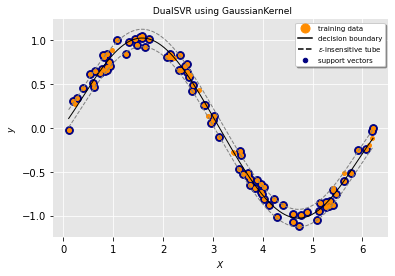

In [61]:
grid = GridSearchCV(DualSVR(loss=squared_epsilon_insensitive, 
                            optimizer=AdaGrad, 
                            max_iter=10000, 
                            learning_rate=1.),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)

In [62]:
nonlinear_lagrangian_dual_l2_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l2_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_l2_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l2_svr.tex', 
                                                     caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_2$-SVR results', 
                                                     label='nonlinear_lagrangian_dual_l2_svr_cv_results', position='H')
nonlinear_lagrangian_dual_l2_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       kernel C   epsilon                                   
reg_bias   poly   1   0.1       8.235232  0.978282   10000   100
                      0.2       8.716630  0.970738   10000   100
                      0.3       8.480382  0.963066   10000    98
                  10  0.1       8.115164  0.981600   10000   100
                      0.2       8.343646  0.978640   10000   100
                      0.3       8.470356  0.972543   10000    99
                  100 0.1       9.089824  0.979231   10000   100
                      0.2       8.650169  0.979959   10000   100
                      0.3       7.813888  0.968573   10000    98
           rbf    1   0.1       9.356709  0.971405   10000    35
                      0.2      10.505933  0.932771   10000    28
                      0.3       9.865885  0.897683   10000    16
                  10  0.1       9.698501  0.986052   10000    68
                      0.2       9.203216  0.979205   10000    35
                      0.3       9.812614  0.945504   10000    34
                  100 0.1       9.452740  0.989507   10000    77
                      0.2       9.319579  0.984410   10000    55
                      0.3       9.517304  0.948853   10000    53
unreg_bias poly   1   0.1       8.688517  0.971836   10000   100
                      0.2       7.715100  0.969615   10000   100
                      0.3       7.565595  0.979246   10000   100
                  10  0.1       8.340514  0.981361   10000   100
                      0.2       8.246735  0.977274   10000   100
                      0.3       7.812046  0.977763   10000   100
                  100 0.1       7.809393  0.978690   10000   100
                      0.2       8.281094  0.979153   10000   100
                      0.3       9.130430  0.976826   10000   100
           rbf    1   0.1       9.946135  0.971405   10000    35
                      0.2       9.118614  0.932774   10000    28
                      0.3       9.868906  0.907758   10000    44
                  10  0.1       9.417278  0.988111   10000    79
                      0.2      10.214749  0.965456   10000    63
                      0.3       9.133241  0.936584   10000    81
                  100 0.1       8.922632  0.989715   10000    86
                      0.2       9.714174  0.982249   10000    75
                      0.3       9.847793  0.942890   10000    75

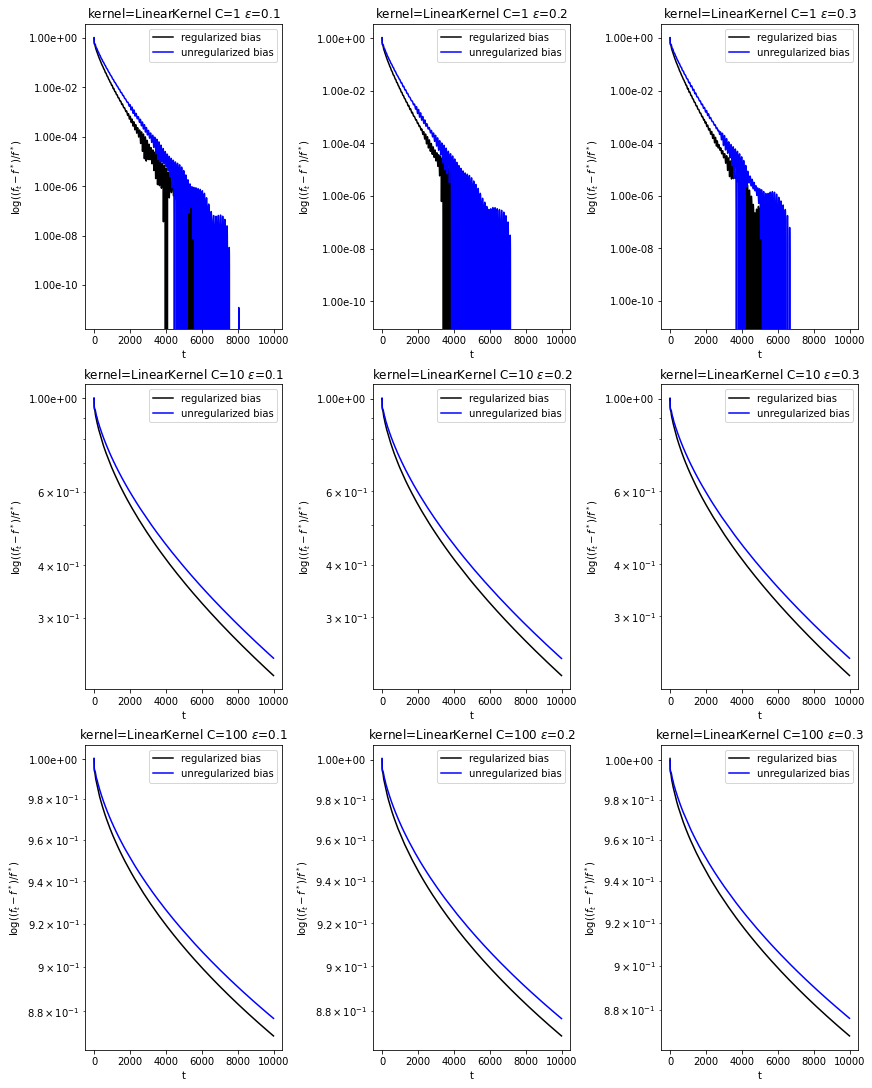

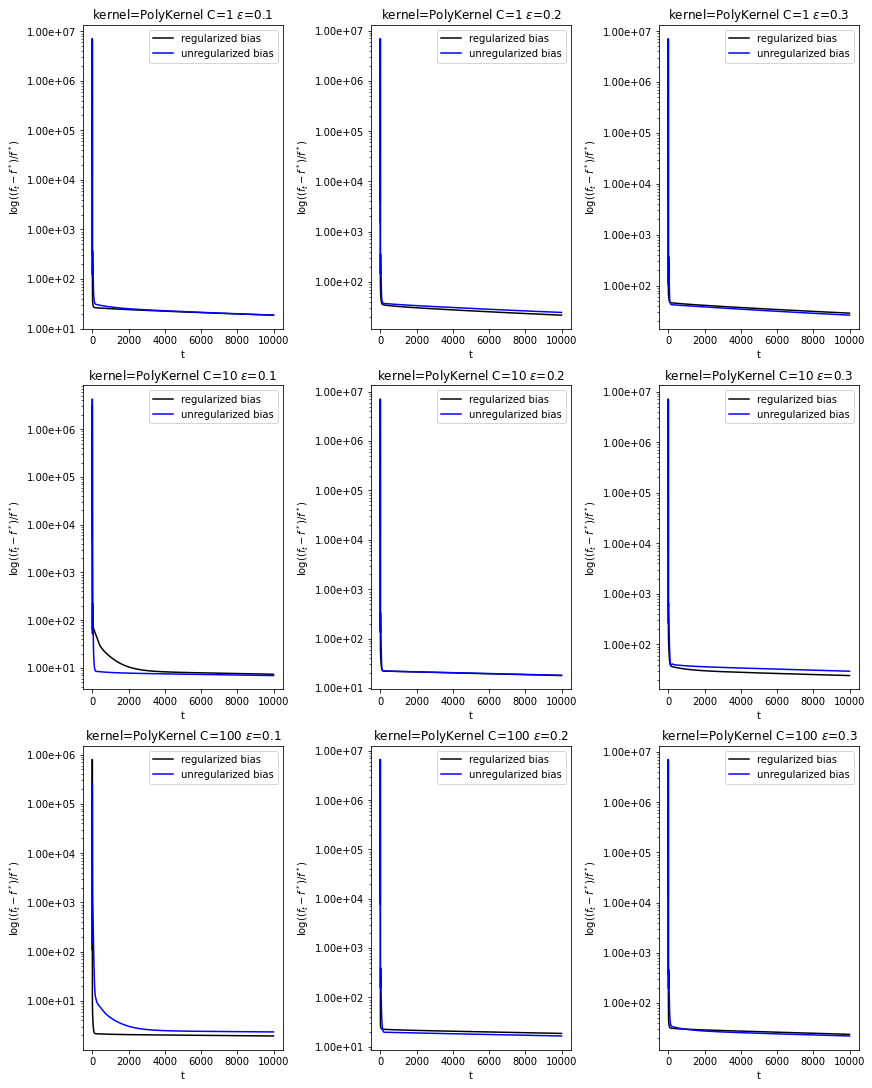

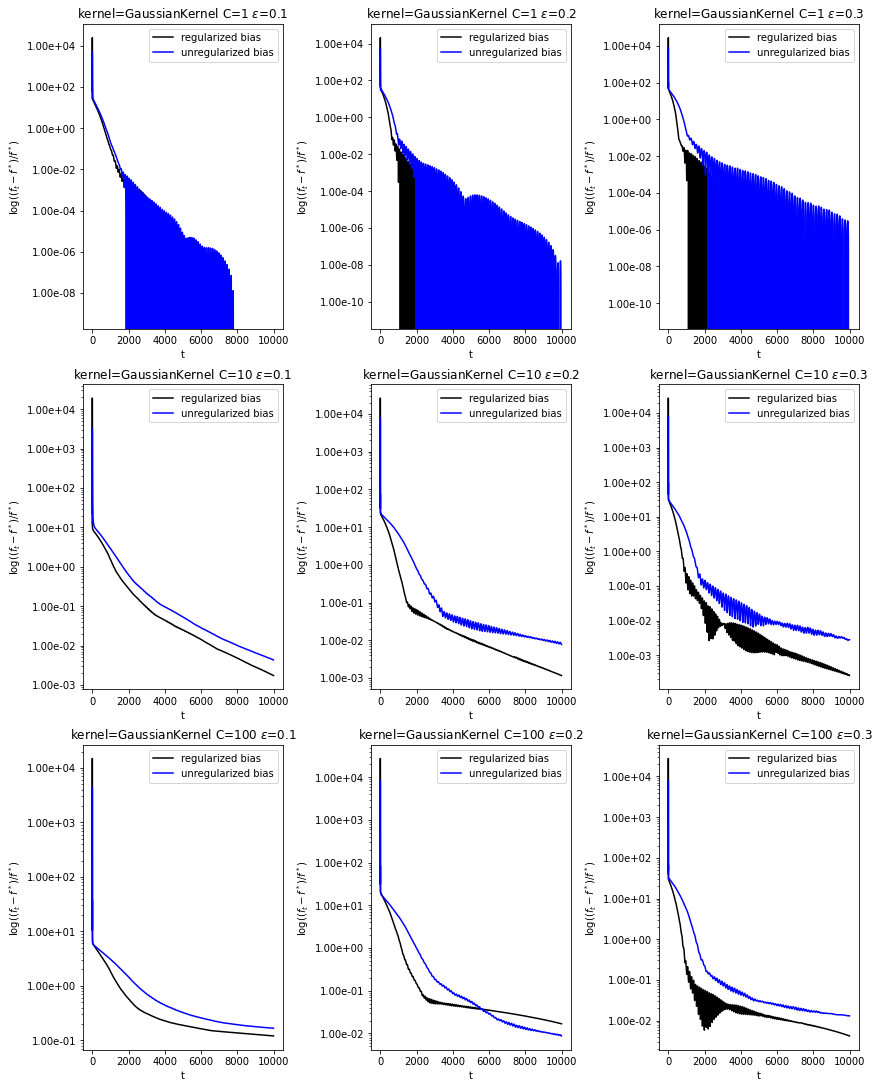

In [63]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
linear_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
linear_ax = linear_fig.subplots(3, 3)
poly_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
poly_ax = poly_fig.subplots(3, 3)
gaussian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
gaussian_ax = gaussian_fig.subplots(3, 3)
axes = {'LinearKernel': linear_ax,
        'PolyKernel': poly_ax,
        'GaussianKernel': gaussian_ax}
for dual, _dict1 in train_loss_history.items():
    for kernel, _dict2 in _dict1.items():
        for (C, _dict3), row_ax in zip(_dict2.items(), axes[kernel]):
            for (eps, history), loss in zip(_dict3.items(), row_ax):
                loss.plot(history, color=colors[dual][0], label=colors[dual][1])
                loss.set_title('kernel={} C={:d} $\epsilon$={:.1f}'.format(kernel, C, eps))
                loss.set_xlabel('t')
                loss.set_yscale('log')
                loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
                loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
                loss.legend().get_frame().set_facecolor('white')
linear_fig.savefig('./tex/img/linear_lagrangian_dual_l2_svr_loss_history.png')
poly_fig.savefig('./tex/img/poly_lagrangian_dual_l2_svr_loss_history.png')
gaussian_fig.savefig('./tex/img/gaussian_lagrangian_dual_l2_svr_loss_history.png')